## binary1mse1binary2mse2

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
import tensorflow 
from tensorflow import keras
from keras.preprocessing.image import load_img, array_to_img, img_to_array


input_dir  = Path('input')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

height = 1400
width = 900
patch_height = 20
patch_width = 20
numbers_of_image = 1513
v1 = width - patch_width + 1
v2 = height - patch_height +1
v3 = int((height / patch_height) * (width / patch_width))
v4 = int(height / patch_height)
train_image_index = 1
train_image_name = "2.jpg"
test_image_index = 1
test_image_name = "4.jpg"
numbers_of_epochs = 5
numbers_of_batch_size = 50


train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    if i>2:
        img = imread(train_cleaned/img)
    else:
        img = imread(train/img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
# plt.show() 


X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(width,height))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(width,height))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)


X=X.reshape((964, 900, 1400))
Y=Y.reshape((690, 900, 1400))
print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)


#create patch of size 28*30 
#total no of patch from one image=270
def patch(x):
    xd=[]
    for i in range(0,v1,patch_width):
        for j in range(0,v2,patch_height):
            xd.append(x[i:i+patch_width,j:j+patch_height])
    xd=np.array(xd)
    return xd

def patch_restore(b):
    res=np.empty((0,height), np.float32)
    cur=b[0]
    for i in range(1,v3):
        if i%v4==0:
            res=np.append(res,cur,axis=0)
            cur=b[i]
        else:
            cur=np.append(cur,b[i],axis=1)
    res=np.append(res,cur,axis=0)
    return res  


f, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(X[train_image_index], cmap='gray')
ax[0].axis('off')

#create patch and restore back to its original form
s=patch(X[train_image_index])
p=patch_restore(s)
ax[1].imshow(p, cmap='gray')
ax[1].axis('off')
# plt.show() 


Xd=patch(X[0])
for i in range(1,numbers_of_image):
    Xd=np.append(Xd,patch(X[i]),axis=0)

Yd=patch(Y[0])
for i in range(1,numbers_of_image):
    Yd=np.append(Yd,patch(Y[i]),axis=0)

print("Size of Xd : ", Xd.shape)
print("Size of Yd : ", Yd.shape)
div = Xd.shape[0]
print(div)


Xd=Xd.reshape((div,patch_width,patch_height,1))
Yd=Yd.reshape((div,patch_width,patch_height,1))
print("Size of Xd : ", Xd.shape)
print("Size of Yd : ", Yd.shape)


f, ax = plt.subplots(1, 2, figsize=(5,5))
ax[0].imshow(Xd[3000].reshape((patch_width,patch_height)),cmap='gray')
ax[0].axis('on')
ax[1].imshow(Yd[3000].reshape((patch_width,patch_height)),cmap='gray')
ax[1].axis('on')
# plt.show() 

# Split the dataset into training and validation.
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(Xd, Yd, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)


from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input,Conv3D
from keras.optimizers import SGD, Adam, Adadelta, Adagrad


def build_autoenocder():
    input_img = Input(shape=(patch_width,patch_height,1), name='image_input')
    
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='Conv1')(input_img)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = Conv2D(16, (4,4), activation='relu', padding='same', name='Conv4')(x)
    x = Conv2D(1, (4,4), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

autoencoder = build_autoenocder()
autoencoder.summary()

# autoencoder.compile(loss='sparse_categorical_crossentropy',
#               optimizer=keras.optimizers.RMSprop(),
#               metrics=['accuracy'])
autoencoder.compile(loss='mse', optimizer='adam',metrics=['accuracy'])


history = autoencoder.fit(X_train, y_train, epochs= numbers_of_epochs, batch_size= numbers_of_batch_size, validation_data=(X_valid, y_valid))
autoencoder.save('model/autoencoder1binary.h5')

test_scores = autoencoder.evaluate(X_valid, y_valid, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])
#graph draw
import matplotlib.pyplot as plt 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('autoencoder1binary1 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("graph_auto1_binary1.jpg")

Total number of images in the training set:  964
Total number of cleaned images found:  690
Total number of samples in the test set:  148
Size of X :  (964, 900, 1400, 1)
Size of Y :  (690, 900, 1400, 1)
Size of X :  (964, 900, 1400)
Size of Y :  (690, 900, 1400)


## testencoder file

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
height......Height
1280
Total number of samples in the test set:  152
index no: 145
shape of patch  (5250, 20, 20, 1)
(1500, 1400)


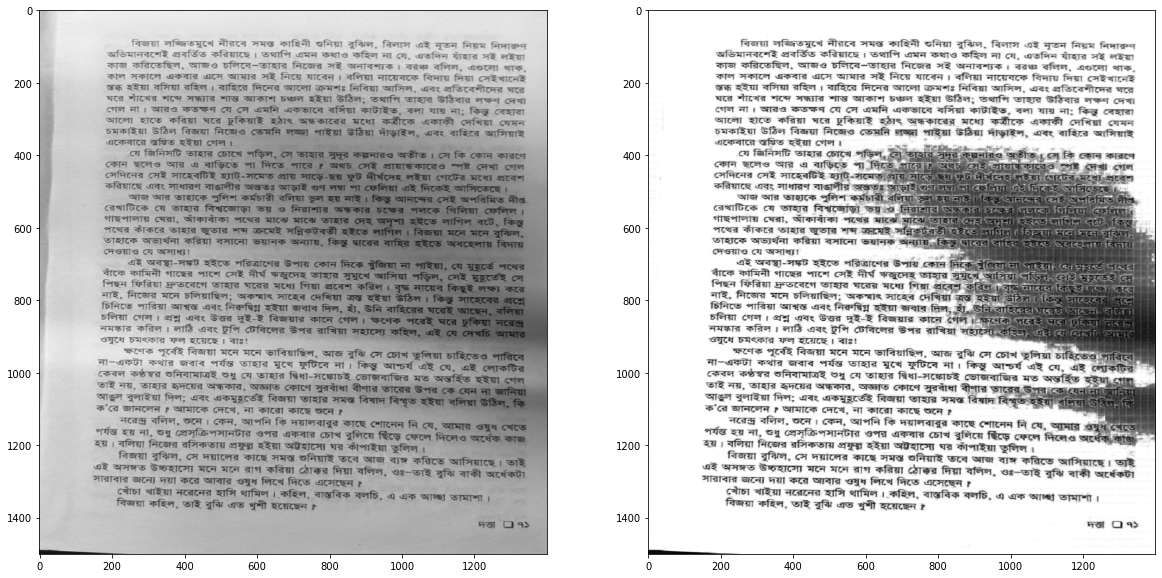

In [1]:

import warnings
warnings.filterwarnings("ignore")
import os
from pathlib import Path
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import load_model
from PIL import Image
#autoencoder1 = load_model('model/618/autoencoder1relu.h5',compile=False)
autoencoder2 = load_model('model/1500/autoencoder1binary.h5',compile=False)
# autoencoder3 = load_model('model/618/autoencoder2mse.h5',compile=False)
# autoencoder4 = load_model('model/618/autoencoder2binary.h5',compile=False)
# autoencoder5 = load_model('model/618/my_model.h5',compile=False)

height = 1400
width = 1500
patch_height = 20
patch_width = 20
v1 = width - patch_width + 1
v2 = height - patch_height +1
v3 = int((height / patch_height) * (width / patch_width))
v4 = int(height / patch_height)
test_image_name = "shadow3.jpg"

import pygame
T_image = cv2.imread('input/test/'+test_image_name,0)
T_height, T_width = T_image.shape[:2]
#T_height = T_image.get_height()
#T_width = T_image.get_width()
print("height......Height")
print(T_height)

input_dir  = Path('input')
test = input_dir / 'test'
test_images = sorted(os.listdir(test))
print("Total number of samples in the test set: ", len(test_images))
k=test_images.index(test_image_name)
print("index no:",k)

testin = load_img(test/ test_images[k], grayscale=True, target_size=(width,height))
testin = img_to_array(testin).astype('float32')/255
testin=testin.reshape((width,height))
# imshow(testin)


#create patch of size 28*30 
#total no of patch from one image=270
def patch(x):
    xd=[]
    for i in range(0,v1,patch_width):
        for j in range(0,v2,patch_height):
            xd.append(x[i:i+patch_width,j:j+patch_height])
    xd=np.array(xd)
    return xd

def patch_restore(b):
    
    res=np.empty((0,height), np.float32)
    cur=b[0]
    for i in range(1,v3):
        if i%v4==0:
            res=np.append(res,cur,axis=0)
            cur=b[i]
        else:
            cur=np.append(cur,b[i],axis=1)
    res=np.append(res,cur,axis=0)
    return res  
testpatch=patch(testin)
p=np.expand_dims(testpatch, axis=3)
print('shape of patch ',p.shape)

#pred1=autoencoder1.predict(p)
pred2=autoencoder2.predict(p)
# pred3=autoencoder3.predict(p)
# pred4=autoencoder4.predict(p)
# pred5=autoencoder5.predict(p)
#pred1=np.squeeze(pred1)
pred2=np.squeeze(pred2)
# pred3=np.squeeze(pred3)
# pred4=np.squeeze(pred4)
# pred5=np.squeeze(pred5)
#pred1=patch_restore(pred1)
pred2=patch_restore(pred2)
# pred3=patch_restore(pred3)
# pred4=patch_restore(pred4)
# pred5=patch_restore(pred5)
print(pred2.shape)


f, ax = plt.subplots(1,2, figsize=(20,15))
ax[0].imshow(testin, cmap='gray')
# ax[0,1].imshow(pred1, cmap='gray')
# ax[1,0].imshow(testin, cmap='gray')
ax[1].imshow(pred2, cmap='gray')
# ax[2,0].imshow(testin, cmap='gray')
# ax[2,1].imshow(pred3, cmap='gray')
# ax[3,0].imshow(testin, cmap='gray')
# ax[3,1].imshow(pred4, cmap='gray')
# ax[4,0].imshow(pred5, cmap='gray')
# plt.show()
#dim = (T_height,T_width)
#pred1 = cv2.resize(pred1, (T_width, T_height), interpolation = cv2.INTER_AREA) 
pred2 = cv2.resize(pred2, (T_width, T_height), interpolation = cv2.INTER_AREA)
# pred3 = cv2.resize(pred1, (T_width, T_height), interpolation = cv2.INTER_AREA)
# pred4 = cv2.resize(pred1, (T_width, T_height), interpolation = cv2.INTER_AREA)
# pred5 = cv2.resize(pred1, (T_width, T_height), interpolation = cv2.INTER_AREA)


from matplotlib import image

#image.imsave('output/withoutpoolin1mse.png',pred1,cmap='gray')
image.imsave('output/'+test_image_name,pred2,cmap='gray')
# image.imsave('output/withpooling2mse.png',pred3,cmap='gray')
# image.imsave('output/withpooling2binary.png',pred4,cmap='gray')
# image.imsave('output/mse.png',pred5,cmap='gray')
